In [1]:
import geopandas as gpd
import xarray as xr
import rioxarray 
from shapely.geometry import box
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from geocube.api.core import make_geocube



root = Path.cwd()

In [2]:
polys = gpd.read_file(root / 'beech_stands' / 'Beech Stand Polygons.kml')
polys = polys.reset_index().to_crs(26918)

In [4]:
SITE = 'roundtop'

sentinel = xr.open_dataarray(root / 'sentinel_data' / f'2023_{SITE}.nc')
# set crs and spatial dims
sentinel = sentinel.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

In [58]:
# create bounding box polygon of sentinel array
bounds = sentinel.rio.bounds()
sentinel_bbox = box(*bounds)

# get the polygons that intersect with the bounding box
df = gpd.GeoDataFrame({"id":1,"geometry":[sentinel_bbox]})
idx = df.sindex.query(polys.geometry, predicate="intersects")[0]
polys_selected = polys.iloc[idx]
polys_selected.shape

# get index numbers for beech/nonbeech polygons
beech_idx = polys_selected.loc[polys_selected.Name!='non-beech stand']['index'].astype('float').values
nonbeech_idx = polys_selected.loc[polys_selected.Name=='non-beech stand']['index'].astype('float').values

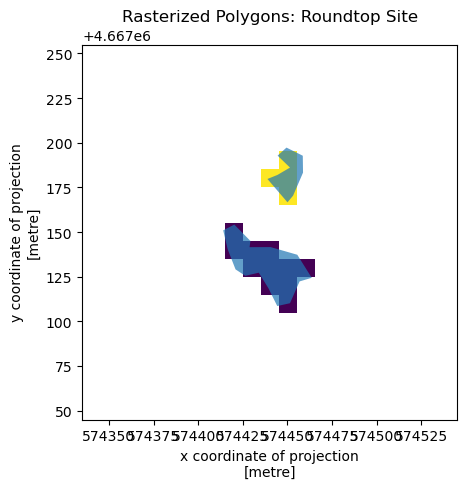

In [6]:
# rasterize polygons
out_grid = make_geocube(
    vector_data=polys_selected,
    measurements=["index"],
    like=sentinel, # ensure the data are on the same grid
)


 # plot rasterized polygons overlaid with vector polygons
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

p = out_grid.index.plot.imshow(ax=ax)
polys_selected.plot(ax=ax,alpha=.7)
p.colorbar.remove()
plt.title(f'Rasterized Polygons: {SITE.title()} Site')
plt.tight_layout()
plt.show()

In [60]:
def make_pixel_df(s,rast_polys,idx):

    pixels = s.where(rast_polys.index==idx).assign_coords({'time':[str(x.astype('datetime64[D]')) for x in s.time.values]})

    stacked = pixels.stack(spatial=('x','y'))
    transposed = stacked.transpose('spatial', 'band', 'time')
    # convert to dataframe
    df = transposed.to_dataframe(name='value').unstack(['band', 'time'])

    df = df.loc[:,('value')]
    df = df.reset_index()

    df.columns = [f'{x[0]}_{x[1]}' for x in df.columns]

    df.rename(columns={df.columns[0]:'x',df.columns[1]:'y'},inplace=True)

    df = df.drop(['x','y'],axis=1)

    df = df[df.isna().sum(axis=1) == 0]
    print(df.shape)

    return df

In [56]:


df

,B02_2023-01-15,B02_2023-02-04,B02_2023-02-11,B02_2023-02-14,B02_2023-03-16,B02_2023-03-21,B02_2023-03-26,B02_2023-04-02,B02_2023-04-12,B02_2023-05-10,...,B12_2023-09-07,B12_2023-09-14,B12_2023-09-27,B12_2023-10-04,B12_2023-10-27,B12_2023-11-03,B12_2023-11-16,B12_2023-11-18,B12_2023-12-13,B12_2023-12-21
178,0.0570,0.1132,0.0792,0.0358,0.2298,0.2254,0.1784,0.1694,0.0534,0.0579,...,0.0738,0.0810,0.0631,0.0806,0.1133,0.1172,0.1030,0.1002,0.0817,0.0891
179,0.0581,0.1092,0.0582,0.0350,0.1948,0.1854,0.1364,0.1312,0.0495,0.0584,...,0.0801,0.0829,0.0702,0.0877,0.1173,0.1171,0.1075,0.1070,0.0817,0.0930
200,0.0478,0.1066,0.0542,0.0306,0.1656,0.1510,0.1674,0.1482,0.0467,0.0576,...,0.0801,0.0829,0.0702,0.0877,0.1173,0.1171,0.1075,0.1070,0.0817,0.0930
201,0.0526,0.1190,0.0538,0.0277,0.2178,0.1642,0.1794,0.1440,0.0494,0.0579,...,0.0801,0.0829,0.0702,0.0877,0.1173,0.1171,0.1075,0.1070,0.0817,0.0930
221,0.0586,0.1226,0.0574,0.0348,0.2612,0.1654,0.1830,0.1802,0.0492,0.0588,...,0.0762,0.0835,0.0661,0.0881,0.1182,0.1148,0.1002,0.0979,0.0733,0.0810
222,0.0525,0.1196,0.0528,0.0286,0.2678,0.2136,0.1990,0.1940,0.0520,0.0613,...,0.0762,0.0835,0.0661,0.0881,0.1182,0.1148,0.1002,0.0979,0.0733,0.0810
223,0.0600,0.1108,0.0534,0.0275,0.2472,0.2264,0.2096,0.1304,0.0526,0.0620,...,0.0787,0.0793,0.0678,0.0876,0.1142,0.1184,0.1058,0.1030,0.0756,0.0884
243,0.0488,0.1024,0.0510,0.0245,0.2358,0.1890,0.2414,0.1870,0.0466,0.0598,...,0.0762,0.0835,0.0661,0.0881,0.1182,0.1148,0.1002,0.0979,0.0733,0.0810
244,0.0698,0.1368,0.0534,0.0277,0.2490,0.2300,0.2368,0.1792,0.0545,0.0605,...,0.0787,0.0793,0.0678,0.0876,0.1142,0.1184,0.1058,0.1030,0.0756,0.0884
245,0.0756,0.1662,0.0495,0.0292,0.2236,0.2590,0.2104,0.1626,0.0494,0.0576,...,0.0787,0.0793,0.0678,0.0876,0.1142,0.1184,0.1058,0.1030,0.0756,0.0884


### Get mean values for plots

In [7]:
# add satellite data to dataset
out_grid['sentinel'] = (sentinel.dims, sentinel.values, sentinel.attrs, sentinel.encoding)

# calculate means for each group (polygon)
grouped_sentinel = out_grid.drop_vars("spatial_ref").groupby(out_grid.index)
grid_mean = grouped_sentinel.mean().rename({"sentinel": "sentinel_mean"})

c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension index because variable index is not a coordinate. To create an index for index, please first call `.set_coords('index')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [8]:
zonal_stats = grid_mean.to_dataframe()



# put beech/nonbeech into seperate dataframes 
beech_means = zonal_stats.loc[beech_idx]
nonbeech_means = zonal_stats.loc[nonbeech_idx]

In [9]:
def unstack_and_relabel_dfs(df,idx=None):
    """Reformat and tidy dataframes produced by calling to_dataframe() on zonal stats array"""

    df_unstack = df.unstack(level='band').droplevel('band',axis=1)
    df_unstack.columns = sentinel.band.values

    if len(np.unique(df_unstack.index.get_level_values(level='index'))) < 2: # check if multiple polygons
        df_unstack = df_unstack.reset_index()
        df_unstack['time'] = [str(x.astype('datetime64[D]')) for x in sentinel.time.values]
        return df_unstack
    
    else:   # if multiple polygons, return a list of dataframes
        df_list = []
        for i in range(0,len(idx)):
            df1 = df_unstack.loc[idx[i]]
            df1 = df1.reset_index()
            df1['time'] = [str(x.astype('datetime64[D]')) for x in sentinel.time.values]
            df_list.append(df1)
        
        return df_list
        

        

In [10]:
# reformat and label dataframes
beech_means = unstack_and_relabel_dfs(beech_means)
nonbeech_means = unstack_and_relabel_dfs(nonbeech_means)

In [11]:
# save to disk
beech_means.to_csv(root / 'output' / f'{SITE}_beech_polygon_means.csv')
nonbeech_means.to_csv(root / 'output' / f'{SITE}_nonbeech_polygon_means.csv')